## Großes Projekt "Netzwerflussproblem"
#### Alexander M. Westphal, Klaus Riedl, Robert Taglauer

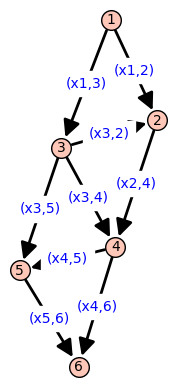

In [18]:
import numpy as np
from scipy.optimize import linprog
from numpy.linalg import solve

#Plotten der funktion zu unserem Beispiel 
D = DiGraph({ 1:[2,3], 2:[4],3:[2,4,5], 4:[5,6], 5:[6]}, loops=True)
for u,v,l in D.edges():
    D.set_edge_label(u,v,'(x' + str(u) + ',' + str(v) + ')')
D.graphplot(edge_labels=True).show()

#Todo Alex:!!!
#-> Userinterface zum eingabe von Verbindungspunten kosten und max trans 
#-> daraus Inzidenzmatrix generieren
#-> daraus maxTrans und kosten Vektor generieren
#-> nullvektor generieren
#-> Zielvektor generieren


input=6

#Ausgangsbasis: Inzidenzmatrix
#für min kost 
matrixInd = Matrix([[1,1,0,0,0,0,0,0,0],[-1,0,1,-1,0,0,0,0,0],[0,-1,0,1,1,1,0,0,0],[0,0,-1,0,-1,0,1,1,0],[0,0,0,0,0,-1,-1,0,1],[0,0,0,0,0,0,0,-1,-1]])
#für max fluss 
testm = Matrix([[1,1,0,0,0,0,0,0,0,-1],[-1,0,1,-1,0,0,0,0,0,0],[0,-1,0,1,1,1,0,0,0,0],[0,0,-1,0,-1,0,1,1,0,0],[0,0,0,0,0,-1,-1,0,1,0],[0,0,0,0,0,0,0,-1,-1,1]])

#ToDo -> Input soirtieren nach aufsteigend
#
maxTrans = vector([5,4,6,3,2,3,+np.inf,4,5])
kosten = vector([2,3,3,0,1,2,1,3,5])

x12,x13,x24,x32,x34,x35,x45,x46,x56 = var('x12,x13,x24,x32,x34,x35,x45,x46,x56')
ziel = vector([input,0,0,0,0,-input])
loesung = vector([x12,x13,x24,x32,x34,x35,x45,x46,x56])
null = vector([0,0,0,0,0,0,0,0,0])




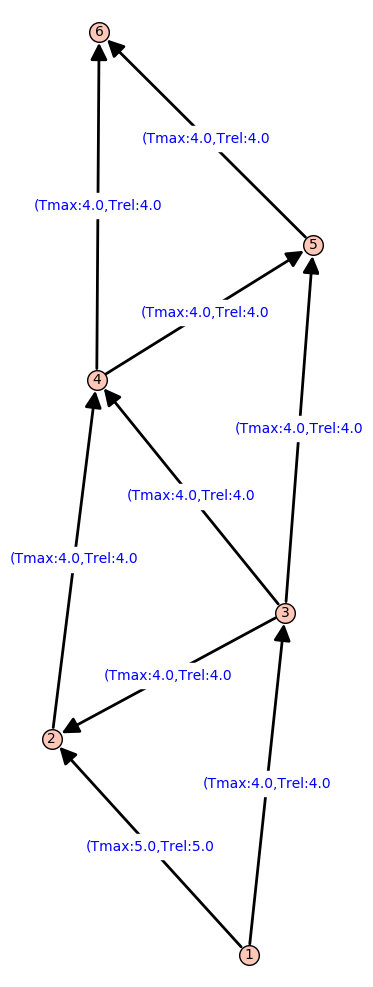

Maximalerfluss: 9.0


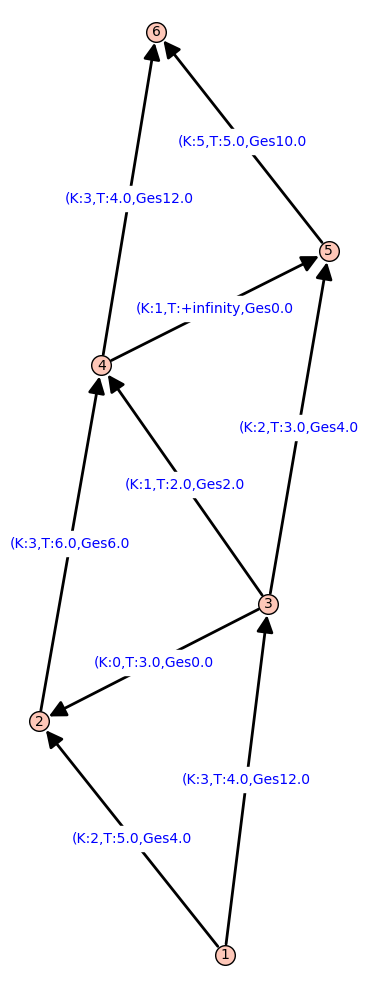

Gesamtkosten: 50.0


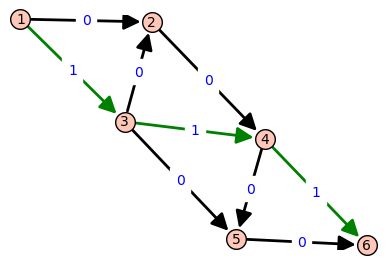

Gesamtkosten: 7.0


     con: array([0., 0., 0., 0., 0., 0.])
     fun: 7.0
 message: 'Optimization terminated successfully.'
     nit: 19
   slack: array([], dtype=float64)
  status: 0
 success: True
       x: array([0., 1., 0., 0., 1., 0., 0., 1., 0.])

In [19]:
def plottMinkost(minik,minKost,entscheid):
    ''' Method to Plot the min-cost'''
    D = DiGraph({ 1:[2,3], 2:[4],3:[2,4,5], 4:[5,6], 5:[6]}, loops=True)
    d={0: "black", 1: "green"}
    i=0
    if(entscheid):
        for u,v,l in D.edges():
            D.set_edge_label(u,v,0 if minik.item(i)==0 else 1)
            i=i+1
        D.graphplot(edge_labels=True,edge_colors=D._color_by_label(d)).show()
        print("Gesamtkosten: "+ str(minKost.get('fun')))
    else:
        for u,v,l in D.edges():
            D.set_edge_label(u,v,'(K:' + str(kosten[i]) + ',T:'+ str(maxTrans[i]) + ',Ges' + str((kosten[i]*minik.item(i))))
            i=i+1
        D.graphplot(edge_labels=True).show(figsize =15)
        print("Gesamtkosten: "+str(minKost.get('fun')))
        
def plotMaxFluss(maxif,maxFluss):
    ''' Method to Plot the Maxflow '''
    i=0
    d={0: "black", 1: "green"}
    D = DiGraph({ 1:[2,3], 2:[4],3:[2,4,5], 4:[5,6], 5:[6]}, loops=false)
    for u,v,l in D.edges():
        D.set_edge_label(u,v,'(Tmax:'+ str(maxTrans[i]) + ',Trel:' + str(maxif.item(i)))
        i=+1
    D.graphplot(edge_labels=True).show(figsize =15)
    print("Maximalerfluss: "+str(maxFluss.get('fun')*-1))
        

        
#Berrechnet den Maximalen Fluss mithilfe scipy bibiliothek 
def maxflussMitKapa(zielMenge,traVec,indMatrix):
    size=len(traVec)
    
    knoten = indMatrix.nrows()
    
    A = np.array(indMatrix) #Inzidenzmatrix
    c=np.zeros(size+1)#c zu minimieren
    c[size]= (-1) # nullvektor mir letzten eintrag der für x6,1 steht -1 da wir keine festen input werte haben 
    
    b=np.zeros(knoten) #nullvektor um sicher zu stelle das wir eine lösung erhalten wo wir sicher sind das alles von der Sekante zu Quelle auch wieder zur Sekannte kommt 
   
    l=np.zeros(size+1)#lower bound -> 0 <= x
    u = np.array(traVec) #max transport x <= u
    u =np.append(u,np.inf) #max trans,+inf -> wegen eingefügten Kante von Sekante zur Quelle
    lb = l #lower bound for x array
    ub = u #upper bound for x array
    maxFluss = linprog(c, A_ub=A, b_ub=b,bounds=list(zip(lb,ub )))
    maxif=maxFluss.get('x')
    plotMaxFluss(maxif,maxFluss)
    return maxFluss
    

def minKostMitKapa(zielMenge,traVec,kostVec,indMatrix,entscheid):
    ''' Method calculate the the min cost depending on kapacitiy or not
        @param entscheid whether the function should consider the Capacity or not
        @param zielmenge Max Amount of things to transport
        @param traVec Tranpsort-Vector max amount of things can be transported
        @param kostVec Cost-Vector reprasenting the cost for a path
        @indMatrix inzidenzmatirx
    '''
    size=len(traVec)
   
    #entscheiden minkosten unabhänig von Transport Kapazität oder mit
    if(entscheid):#wenn ich die kosten von einer Menge herrausfinden will
        zm=1#1 als zielmenge festlegen da wir nur an den kosten von einem Durchgang interessiert sind 
        r = np.arange(size)
        a =[]
        for x in r:
            a.append(1)
            u=a #u auf einservektor setzten um zu sichern das alle Kanten zugänglich sind 
                #auf 2 setzten oder höher nicht notwendig da ein rücksprung nur höhere Kosten verursachen würde
    else:
        zm=zielMenge#zielmenge wie übergeben
        u = np.array(traVec) #max transport x <= u 
    knoten=indMatrix.nrows() #anzahl der knoten

    A = np.array(indMatrix)#Inzidenzmatrix
    c=np.array(kostVec)#zu minimiere -> hier Kostenvektor 
    b=np.zeros(knoten) # vektor erstes element zm und letztes zm -> da wir einen fest geschriebenen Input haben
    b[knoten-1]= (-zm)
    b[0]= (zm)

    l=np.zeros(size) #lower bound -> 0 <= x

    lb = l #lower bound for x array
    ub = u #upper bound for x array
    minKost = linprog(c, A_eq=A, b_eq=b,bounds=list(zip(lb,ub )))
   # plottMinkost()
    minik=minKost.get('x')
    plottMinkost(minik,minKost,entscheid)
    plottMinkost
    return minKost 
    

maxflussMitKapa(6,maxTrans,testm)
minKostMitKapa(6,maxTrans,kosten,matrixInd,false)
minKostMitKapa(6,maxTrans,kosten,matrixInd,true)


In [20]:
#9-13 Seiten  -> Dokumentation
#5-6 min Pro person -> Präsentation

